In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

import tensorflow as tf

# Disable mixed precision
tf.keras.mixed_precision.set_global_policy('float32')
# Your model creation, compilation, and training code goes here

print(tf.__version__)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2.13.0


In [10]:
import os.path
from os import path

# Define the main folder where you want to create subdirectories
main_folder = '/content/sample_data/train/'

# List of subdirectory names you want to create
subdirectories = ['Antelope', 'Badger', 'Coyote', 'Hedgehog', 'Hornbill', 'Okapi', 'Otter', 'Pelecaniformes']

# Create subdirectories within the main folder
for subdir in subdirectories:
    folder_path = os.path.join(main_folder, subdir)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created directory: {folder_path}")

Created directory: /content/sample_data/train/antelope
Created directory: /content/sample_data/train/saola
Created directory: /content/sample_data/train/snowLeapord
Created directory: /content/sample_data/train/vaquita
Created directory: /content/sample_data/train/aye-aye
Created directory: /content/sample_data/train/pangolin
Created directory: /content/sample_data/train/pelecanifornes
Created directory: /content/sample_data/train/otter
Created directory: /content/sample_data/train/okapi
Created directory: /content/sample_data/train/hornbill
Created directory: /content/sample_data/train/hedgehog
Created directory: /content/sample_data/train/coyote
Created directory: /content/sample_data/train/badger


# Loading Dataset

In [54]:
import os.path
from os import path

#path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
path= '/content/sample_data/train/'

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [55]:
df.sample(7)

,imgpath,labels,encoded_labels
326,/content/sample_data/train/pelecanifornes/3f0b...,pelecanifornes,7
390,/content/sample_data/train/otter/0dea6f9641.jpg,otter,6
69,/content/sample_data/train/coyote/36f0afcd07.jpg,coyote,2
197,/content/sample_data/train/hornbill/5bfb6e3dcf...,hornbill,4
371,/content/sample_data/train/otter/74a0824dba.jpg,otter,6
243,/content/sample_data/train/badger/1f06d5b24c.jpg,badger,1
221,/content/sample_data/train/hornbill/0e821633a5...,hornbill,4


# Split the Dataset into Train & Test

In [56]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].sample(8))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].sample(8))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].sample(8))
print(test_df.shape)

----------Train-------------
                                               imgpath          labels
40   /content/sample_data/train/antelope/7e12bc4942...        antelope
23     /content/sample_data/train/otter/5d25066165.jpg           otter
145  /content/sample_data/train/antelope/6aa06f252d...        antelope
105  /content/sample_data/train/pelecanifornes/4caa...  pelecanifornes
3    /content/sample_data/train/hornbill/6bc275c92e...        hornbill
8     /content/sample_data/train/badger/2c8396c663.jpg          badger
123    /content/sample_data/train/otter/3cf7df2974.jpg           otter
142   /content/sample_data/train/coyote/030b91da73.jpg          coyote
(336, 3)
--------Validation----------
                                              imgpath    labels
2    /content/sample_data/train/badger/2e5a00c0a5.jpg    badger
27  /content/sample_data/train/antelope/9a58695d48...  antelope
20  /content/sample_data/train/antelope/1d556456dc...  antelope
85  /content/sample_data/train/antelop

# Show sample from data

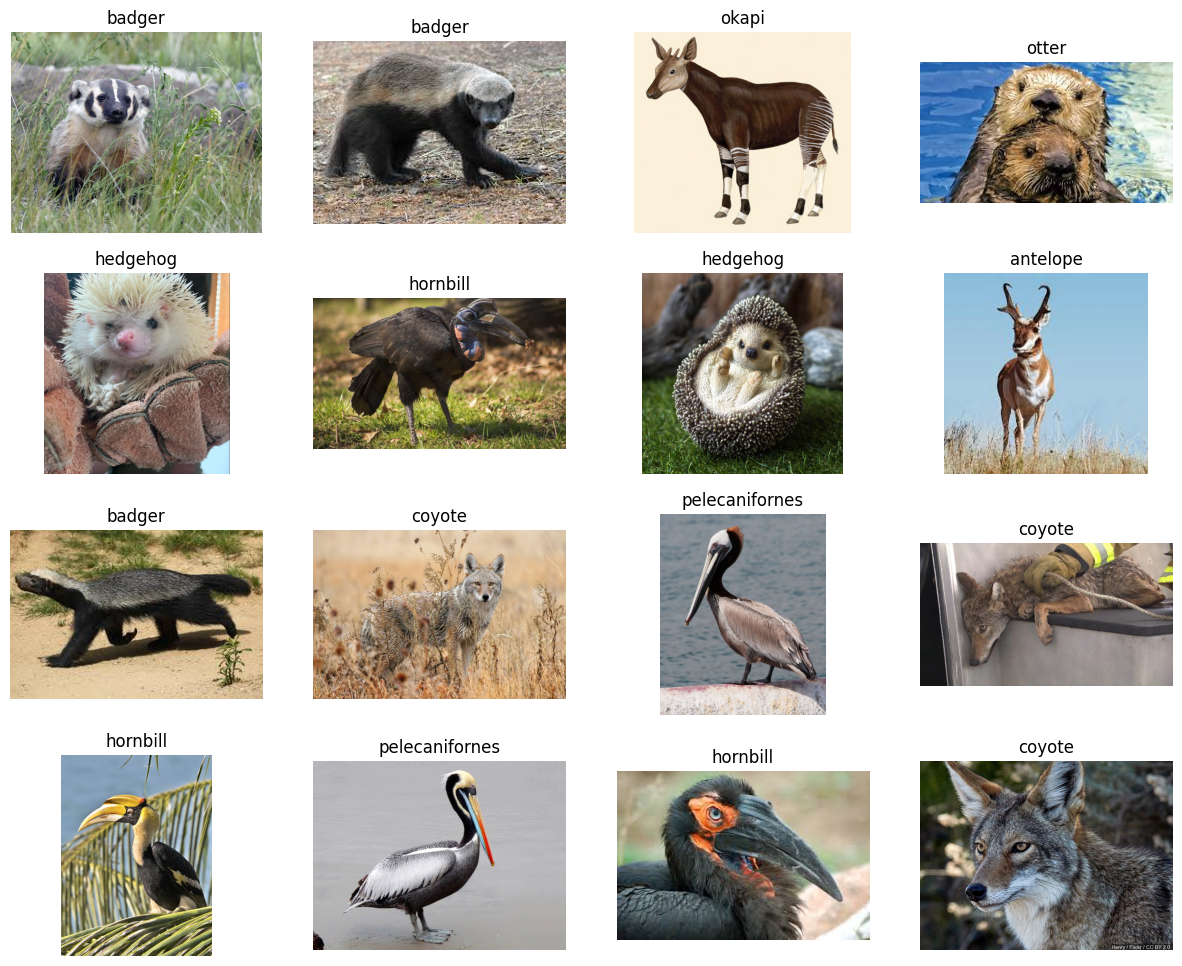

In [57]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [58]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 336 validated image filenames belonging to 8 classes.
Found 100 validated image filenames belonging to 8 classes.
Found 44 validated image filenames belonging to 8 classes.
CPU times: user 25.7 ms, sys: 963 µs, total: 26.7 ms
Wall time: 28.7 ms


# Model Structure

In [59]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [60]:
num_classes = len(set(train_images.classes))
print(num_classes)

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes, activation="softmax")(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

8
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 256)               393472    
                                                                 
 activation_7 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 256)               10

# Training : Transfer Learning

In [61]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
23/23 [==============================] - 82s 3s/step - loss: 1.7431 - accuracy: 0.5774 - val_loss: 1.3203 - val_accuracy: 0.9600 - lr: 5.0000e-04
Epoch 2/10
23/23 [==============================] - 64s 3s/step - loss: 1.3766 - accuracy: 0.9196 - val_loss: 1.2993 - val_accuracy: 0.9700 - lr: 5.0000e-04
Epoch 3/10
23/23 [==============================] - 69s 3s/step - loss: 1.3331 - accuracy: 0.9583 - val_loss: 1.2911 - val_accuracy: 0.9800 - lr: 5.0000e-04
Epoch 4/10
23/23 [==============================] - 70s 3s/step - loss: 1.3179 - accuracy: 0.9792 - val_loss: 1.2895 - val_accuracy: 0.9900 - lr: 5.0000e-04
Epoch 5/10
23/23 [==============================] - 69s 3s/step - loss: 1.3092 - accuracy: 0.9792 - val_loss: 1.2906 - val_accuracy: 0.9800 - lr: 5.0000e-04
Epoch 6/10
23/23 [==============================] - 68s 3s/step - loss: 1.3038 - accuracy: 0.9881 - val_loss: 1.2867 - val_accuracy: 0.9900 - lr: 5.0000e-04
Epoch 7/10
23/23 [==============================] - 70s 3s

# Display model performance

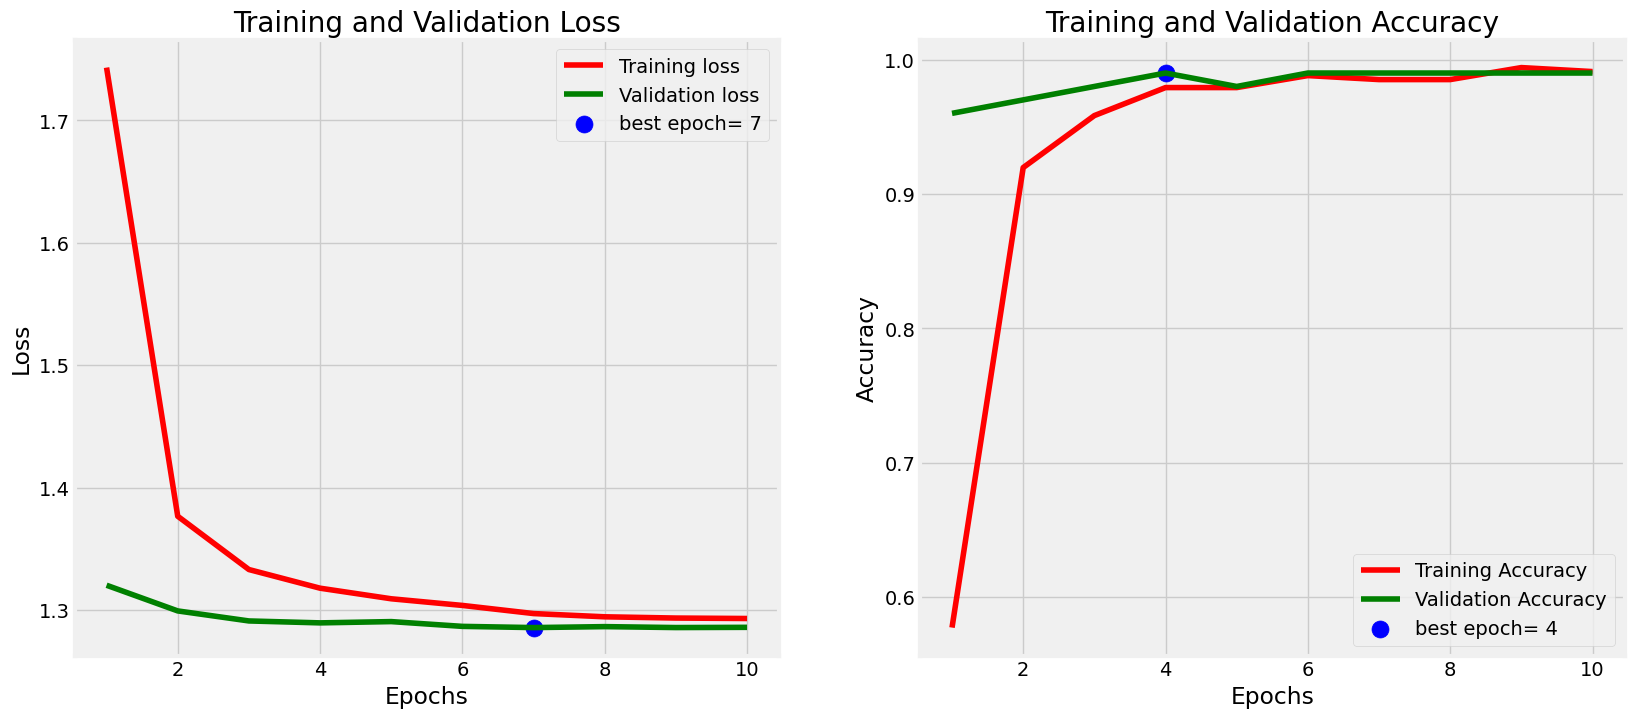

In [62]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [63]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 3 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_6 True
rescaling_10 True
normalization_5 True
rescaling_11 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 256)               393472    
                                                                 
 activation_7 (

# Display model performance

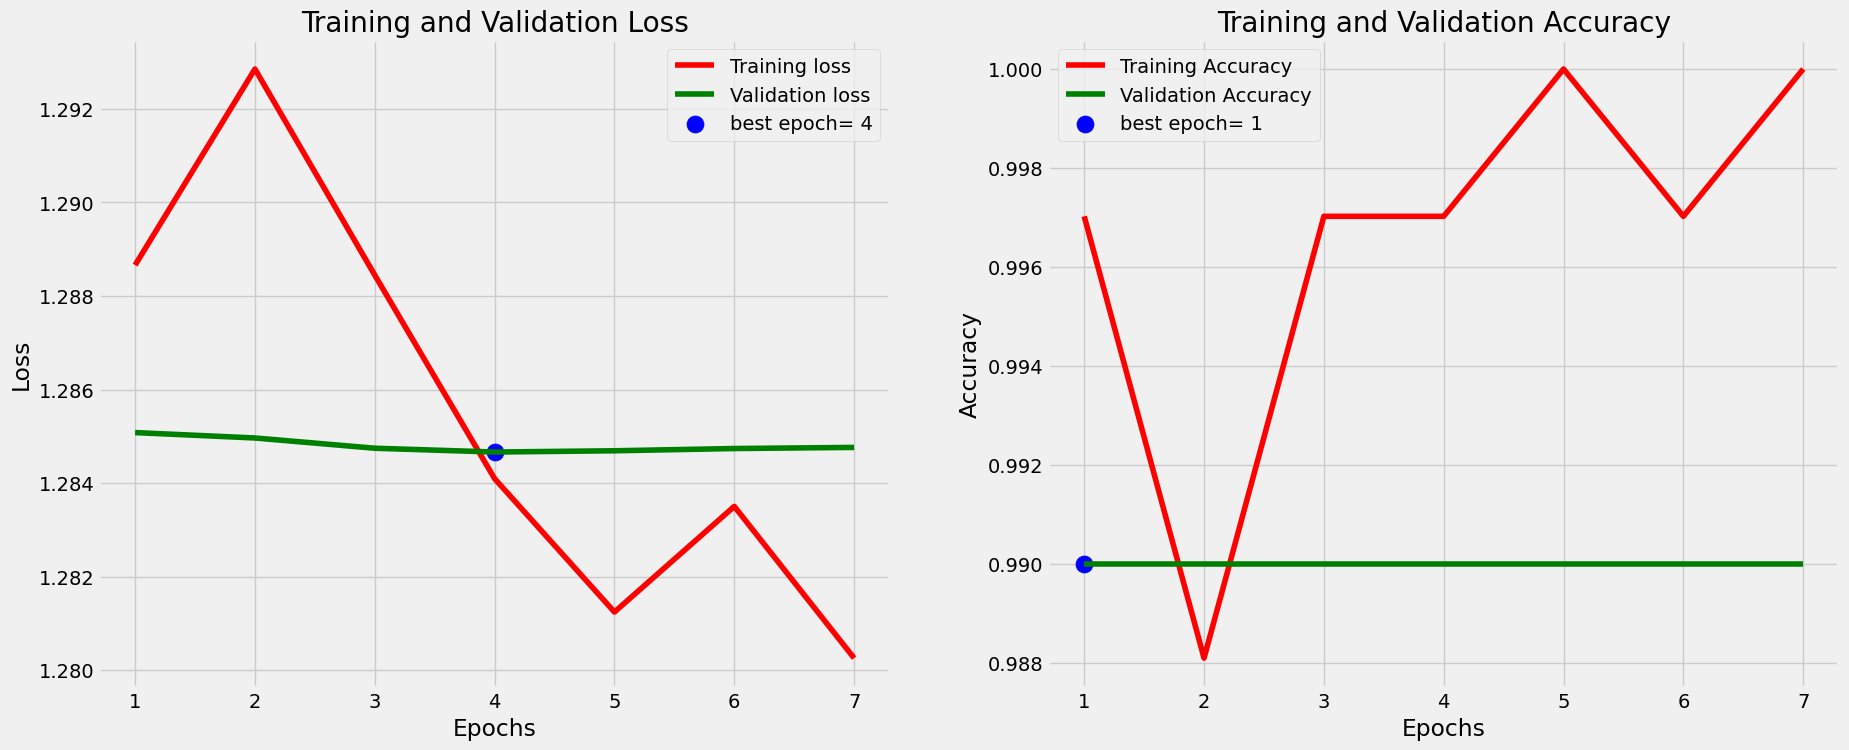

In [65]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [66]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.27619
Test Accuracy: 100.00%


# F1 Score / Recall / Precision

In [67]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

3/3 [==============================] - 9s 2s/step
F1 Score: 1.0
                precision    recall  f1-score   support

      antelope       1.00      1.00      1.00         7
        badger       1.00      1.00      1.00        10
        coyote       1.00      1.00      1.00         6
      hedgehog       1.00      1.00      1.00         3
      hornbill       1.00      1.00      1.00         4
         okapi       1.00      1.00      1.00         5
         otter       1.00      1.00      1.00         5
pelecanifornes       1.00      1.00      1.00         4

      accuracy                           1.00        44
     macro avg       1.00      1.00      1.00        44
  weighted avg       1.00      1.00      1.00        44



# Get Predictions

In [68]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

3/3 [==============================] - 6s 2s/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,2,coyote,2,coyote,/content/sample_data/train/coyote/6e66339f51.jpg,0.279665
1,1,2,coyote,2,coyote,/content/sample_data/train/coyote/162fb4d62e.jpg,0.279705
2,2,7,pelecanifornes,7,pelecanifornes,/content/sample_data/train/pelecanifornes/0b81...,0.279706
3,3,2,coyote,2,coyote,/content/sample_data/train/coyote/185e168504.jpg,0.279702
4,4,6,otter,6,otter,/content/sample_data/train/otter/73e1799e95.jpg,0.279535
5,5,3,hedgehog,3,hedgehog,/content/sample_data/train/hedgehog/96a442d710...,0.279707
6,6,0,antelope,0,antelope,/content/sample_data/train/antelope/68eb12a751...,0.279657
7,7,4,hornbill,4,hornbill,/content/sample_data/train/hornbill/0bacaff531...,0.279707


# Print the most confident errors

In [69]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

<Figure size 2000x2000 with 0 Axes>

# Confusion Matrics and Classification Report

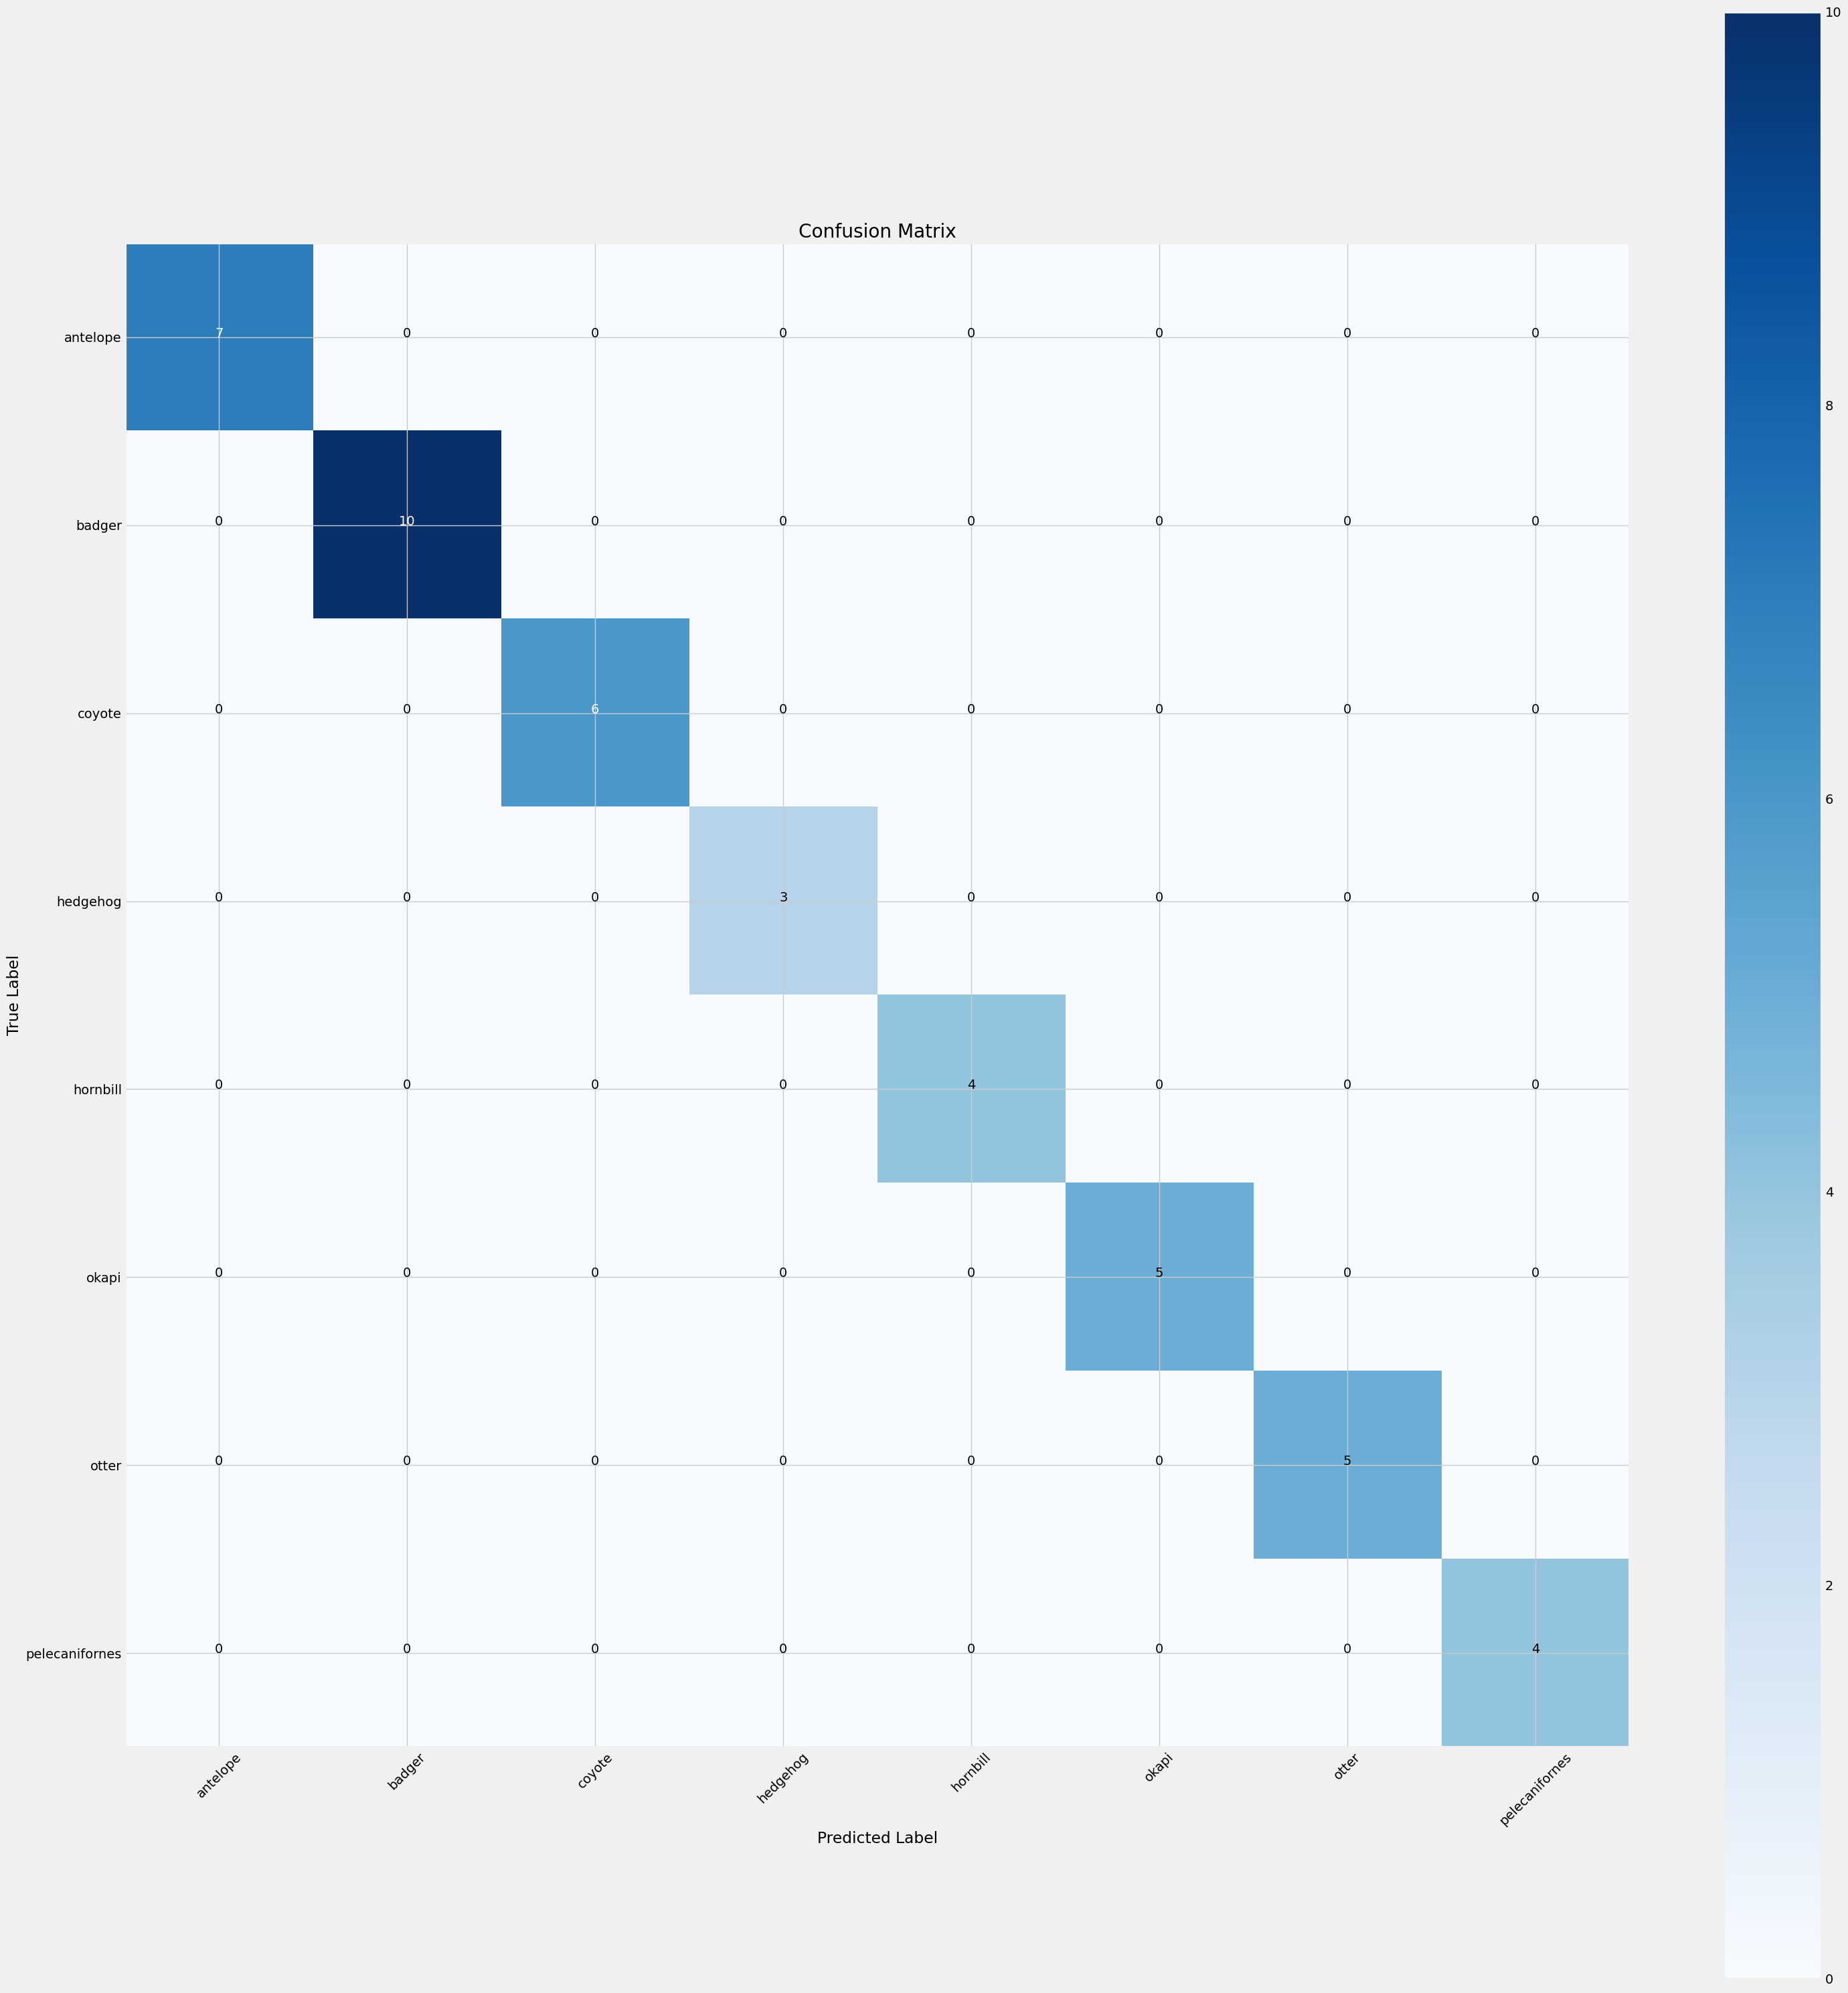

In [70]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [134]:
import re

# Read the animal descriptions from the description.txt file
with open('/content/sample_data/description/animals.txt', 'r') as file:
    description_string = file.read()

# Create a function to extract descriptions for animals
def extract_animal_description(detected_animal, description_text):
    pattern = re.compile(f'{detected_animal}:(.*?)>', re.DOTALL)
    match = pattern.search(description_text)
    if match:
        animal_description = match.group(1).strip()
        # Remove angle brackets
        animal_description = animal_description.strip('<>').strip()
        return animal_description
    else:
        return "Description not found for this animal."

# Replace 'detected_animal' with the name of the detected animal
detected_animal = 'Pelecaniformes'  # Example: Replace with the actual detected animal name
print(detected_animal)
# Extract the description for the detected animal
animal_description = extract_animal_description(detected_animal, description_string)

print(animal_description)


Pelecaniformes
Habitat: Pelecaniformes are found in a variety of aquatic habitats, including coastal regions, lakes, and rivers, worldwide.
Diet: These birds primarily feed on fish, using their large bills and throat pouches to catch and swallow their prey.
Behavior: Pelecaniformes are known for their distinctive fishing techniques, often diving into the water to capture fish. They are social birds and may form colonies for breeding.
Conservation Status: The conservation status of Pelecaniformes varies by species, with some being of Least Concern while others are endangered due to habitat loss and pollution.
Geographical Range: Pelecaniformes can be found in various parts of the world, including coastal areas, islands, and freshwater environments.
Lifespan: The lifespan of Pelecaniformes varies by species, with some living up to 30 years or more.
Reproduction: These birds typically lay eggs in nests, and their young are born helpless and require parental care.
Predators and Threats: Na

In [135]:
import pickle

# Assuming 'model' is your trained machine learning model
with open('trained_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)